In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import time


In [3]:
import custom_functions as cf

## System 34

### Read data

In [4]:
pv_system_data_34 = pd.read_csv('data/ASYNC_annual_data_system_34.txt')

/tmp/ipykernel_8870/618913845.py:1: DtypeWarning: Columns (0,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  pv_system_data_34 = pd.read_csv('data/ASYNC_annual_data_system_34.txt')


In [5]:
pv_system_data_34.head()

,SiteID,Date-Time,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
0,34,2010-08-23 11:13:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34,2010-08-23 11:15:00,117,100400,285,NaN,328,105100,317,0,58,NaN,NaN,-0.999,NaN,NaN,NaN
2,34,2010-08-23 11:17:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,2010-08-23 11:18:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,34,2010-08-23 11:30:00,121,103100,284,NaN,338,108200,316,0,60,NaN,NaN,1,NaN,NaN,NaN


In [6]:
pv_system_data_34.shape

(345003, 17)

In [7]:
pv_system_data_34.columns.unique()

Index(['SiteID', 'Date-Time', 'ac_current', 'ac_power', 'ac_voltage',
       'ambient_temp', 'dc_current', 'dc_power', 'dc_voltage',
       'inverter_error_code', 'inverter_temp', 'module_temp', 'poa_irradiance',
       'power_factor', 'relative_humidity', 'wind_direction', 'wind_speed'],
      dtype='object')

### Delete additional headers

In [8]:
pv_system_data_34 = cf.delete_additional_header(pv_system_data_34)

In [9]:
assert((pv_system_data_34['SiteID'] == 'SiteID').any() == False)

### Rename columns 

In [10]:
pv_system_data_34 = pv_system_data_34.rename(columns = {'SiteID': 'site_id', 'Date-Time': 'timestamp'})

In [11]:
assert((pv_system_data_34['site_id'] == 'SiteID').any() == False)

### Convert data types

In [12]:
pv_system_data_34.dtypes

site_id                object
timestamp              object
ac_current             object
ac_power               object
ac_voltage             object
ambient_temp           object
dc_current             object
dc_power               object
dc_voltage             object
inverter_error_code    object
inverter_temp          object
module_temp            object
poa_irradiance         object
power_factor           object
relative_humidity      object
wind_direction         object
wind_speed             object
dtype: object

In [13]:
pv_system_34_dtypes = {'site_id': int, 'timestamp': 'datetime64', 'ac_current': float, 'ac_power': float, 'ac_voltage': float, 'ambient_temp': float,
                       'dc_current': float, 'dc_power': float, 'dc_voltage': float, 'inverter_error_code': int, 'inverter_temp': float, 'module_temp': float,
                       'poa_irradiance': float, 'power_factor': float, 'relative_humidity': float, 'wind_direction': float, 'wind_speed': float}

In [14]:
pv_system_34_dtypes = cf.convert_data_types(pv_system_data_34, pv_system_34_dtypes)

In [15]:
assert(pv_system_data_34['timestamp'].dtype == 'datetime64[ns]')

## Feature engineering

The column `site_id` has only one value - 34, because in the current data set is only for one PV system. That feature will be dropped, because it carries no new, valuable information.
System 34 has installed power of 146.64 kWp. In the data set columns related to the generated power - `dc_power` and `ac_power`, are in watt dimension. They will be converted in kW, so their values are in the order of the other features' values.

In [16]:
pv_system_data_34 = pv_system_data_34.drop('site_id', axis = 1)

In [17]:
assert('site_id' not in pv_system_data_34.columns)

In [18]:
pv_system_data_34['ac_power'] = pv_system_data_34['ac_power'] / 1000
pv_system_data_34['dc_power'] = pv_system_data_34['dc_power'] / 1000

In [19]:
assert(pv_system_data_34['ac_power'].max() < 150)
assert(pv_system_data_34['dc_power'].max() < 150)

## EDA

### Inverter error code  feature

In [20]:
pv_system_data_34['inverter_error_code'].value_counts()

0      337266
139      7648
160        68
161        11
Name: inverter_error_code, dtype: int64

In [21]:
# pv_system_data_34[pv_system_data_34['inverter_error_code'] == 161]

In [22]:
# pv_system_data_34[pv_system_data_34['inverter_error_code'] == 160].sample(5, random_state=13)

In [23]:
# pv_system_data_34[pv_system_data_34['inverter_error_code'] == 139].sample(5, random_state=13)

The `inverter_error_code` feature consists of errors(number different than 0) and 0 standing for normal operation. That information can be used as labeled data and the problem to be treated as supervised. Although the errors appeared in the data are only three types. Model trained only with those labels is highly expected to fail to recognize other types of inverter errors. Because of that for solving the problem unsupervised method will be used and the inverter error codes will be part  of the evaluation of the model. In this case the information for different type of error won't be used and the feature is converted to binary, where 0 means 'no error' and 1 - 'error occurred'. The total amount of errors in the data is around 2.2%. 

In [24]:
pv_system_data_34['inverter_error_code'] = np.where(pv_system_data_34['inverter_error_code'] != 0, 1, 0)
assert((pv_system_data_34['inverter_error_code'].unique() == [1, 0]).all())

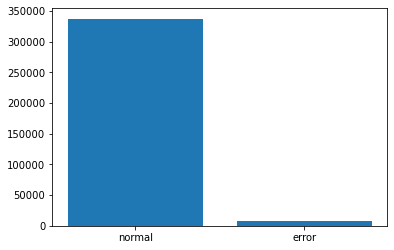

In [25]:
plt.bar(['normal', 'error'], pv_system_data_34['inverter_error_code'].value_counts())
plt.show()

### Record per year

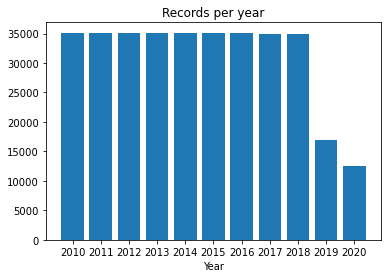

In [26]:
plt.bar(pv_system_data_34['timestamp'].dt.year.unique(), pv_system_data_34['timestamp'].dt.year.value_counts())
plt.title('Records per year')
plt.xlabel('Year')
plt.xticks(range(2010, 2021))
plt.show()

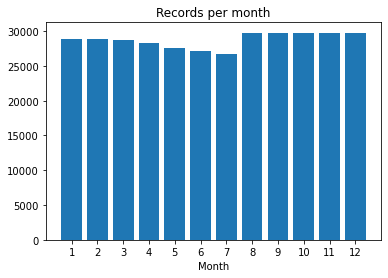

In [27]:
plt.bar(pv_system_data_34['timestamp'].dt.month.unique(), pv_system_data_34['timestamp'].dt.month.value_counts())
plt.title('Records per month')
plt.xlabel('Month')
plt.xticks(range(1, 13))
plt.show()

The last two years have significantly less amount of records. The records per month are quite balanced with least records for July and most records for August, September, November and December.

### Missing data percentage

In [28]:
missing_data_percentage = cf.missing_values_percent(pv_system_data_34, 'timestamp')

In [29]:
missing_data_percentage
missing_data_percentage.style.background_gradient(cmap='Greens', vmax = 10)

,timestamp,ac_current,ac_power,ac_voltage,ambient_temp,dc_current,dc_power,dc_voltage,inverter_error_code,inverter_temp,module_temp,poa_irradiance,power_factor,relative_humidity,wind_direction,wind_speed
timestamp,,,,,,,,,,,,,,,,
2010,0.000000,18.296178,18.296178,18.296178,1.321656,18.296178,18.296178,18.296178,0.000000,18.296178,1.321656,1.321656,18.296178,1.321656,1.321656,1.321656
2011,0.000000,0.037122,0.037122,0.037122,1.087950,0.037122,0.037122,0.037122,0.000000,0.037122,1.087950,1.087950,0.037122,1.087950,1.087950,1.087950
2012,0.000000,6.768907,6.768907,6.768907,0.031298,6.768907,6.768907,6.768907,0.000000,6.768907,0.031298,0.031298,6.768907,0.031298,0.031298,0.031298
2013,0.000000,0.313882,0.313882,0.313882,0.017121,0.313882,0.313882,0.313882,0.000000,0.313882,0.017121,0.017121,0.313882,0.017121,0.017121,0.017121
2014,0.000000,0.048533,0.048533,0.048533,0.548133,0.048533,0.048533,0.048533,0.000000,0.048533,0.548133,0.548133,0.048533,0.548133,0.548133,0.548133
2015,0.000000,0.000000,0.000000,0.000000,0.832261,0.000000,0.000000,0.000000,0.000000,0.000000,0.832261,0.832261,0.000000,0.832261,0.832261,0.832261
2016,0.000000,6.018782,6.018782,6.018782,0.836653,6.018782,6.018782,6.018782,0.000000,6.018782,0.836653,0.836653,6.018782,0.836653,0.836653,0.836653
2017,0.000000,0.014267,0.014267,0.014267,0.236838,0.014267,0.014267,0.014267,0.000000,0.014267,0.236838,0.236838,0.014267,0.236838,0.236838,0.236838
2018,0.000000,0.071465,0.071465,0.071465,15.462238,0.071465,0.071465,0.071465,0.000000,0.071465,15.462238,15.462238,0.071465,15.462238,15.462238,15.462238


As seen from the table above there are records for 11 years. The highest percentages missing data are in `wind_direction`, `ambient_temp`, `module_temp`, `poa_irradiance`, `relative_humidity` columns, with maximum of 94.9% missing records for 2019 and 92.19% for 2020. Those features are related to the weather conditions of the site. Highest percentage missing data for the electrical features are observed in 2010 - 18.29%. 2015 has the least missing records with 0.8% for some weather features and no missing electrical features.
Based on that, a threshold of 10% is established and all years with a feature having missing data above that limit will be dropped. This leads to using 7 years for modeling - 2011 - 2017. 

In [30]:
pv_system_data_34 = cf.drop_years(pv_system_data_34, [2010, 2018, 2019, 2020])

In [31]:
assert(pv_system_data_34['timestamp'][pv_system_data_34['timestamp'].dt.year == 2010].any() == False)
assert(pv_system_data_34['timestamp'][pv_system_data_34['timestamp'].dt.year == 2018].any() == False)
assert(pv_system_data_34['timestamp'][pv_system_data_34['timestamp'].dt.year == 2019].any() == False)
assert(pv_system_data_34['timestamp'][pv_system_data_34['timestamp'].dt.year == 2020].any() == False)